## Regression

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
df_diamonds = pd.read_csv('datasets/diamonds.csv')
df_diamonds.drop(columns={"Unnamed: 0"}, inplace=True)
df_diamonds["price"] = df_diamonds["price"].astype(float)

In [4]:
#df_diamonds['cut']=df_diamonds['cut'].map({'Ideal':5,'Good':4,'Very Good':3,'Premium':2, 'Fair':1})
#df_diamonds['color']=df_diamonds['color'].map({'D':7,'E':6,'F':5,'G':4,'H':3,'I':2,'J':1})
#df_diamonds['clarity']=df_diamonds['clarity'].map({'IF':8,'VVS1':7,'VVS2':6,'VS1':5,'VS2':4,'SI1':3,'SI2':2, 'I1':1})

In [5]:
df_diamonds["carat_cat"] = np.ceil(df_diamonds["carat"] / 0.35)
df_diamonds["carat_cat"].where(df_diamonds["carat_cat"] < 5, 5.0, inplace = True)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# Run the split. Creates on split and shares 20% of the dataset for the test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

# Separate the stratified train set and the test set
for train_index, test_index in split.split(df_diamonds, df_diamonds["carat_cat"]):
    strat_train_set = df_diamonds.loc[train_index]
    strat_test_set = df_diamonds.loc[test_index]

In [12]:
for set in (strat_train_set, strat_test_set):
    set.drop(["carat_cat"], axis = 1, inplace = True)

In [13]:
diamonds = strat_train_set.drop("price", axis = 1)

diamond_labels = strat_train_set["price"].copy()

diamonds_num = diamonds.drop(["cut", "color", "clarity"], axis = 1)
diamonds_num.head()

,carat,depth,table,x,y,z
45345,0.53,62.2,59.0,5.14,5.18,3.21
42382,0.50,62.0,55.0,5.12,5.09,3.16
23473,2.03,62.9,55.0,8.11,8.04,5.08
22354,0.31,62.2,55.0,4.39,4.35,2.72
34838,0.30,60.6,58.0,4.36,4.35,2.64


In [14]:
# Perform the feature scaling on the numeric attributes of the dataset
num_scaler = StandardScaler()
diamonds_num_scaled = num_scaler.fit_transform(diamonds_num)

# Preview 
pd.DataFrame(diamonds_num_scaled).head()

,0,1,2,3,4,5
0,-0.566271,0.315319,0.688758,-0.527675,-0.483618,-0.472738
1,-0.629629,0.175790,-1.100896,-0.545511,-0.561970,-0.544677
2,2.601590,0.803673,-1.100896,2.121075,2.006224,2.217773
3,-1.030891,0.315319,-1.100896,-1.196551,-1.206195,-1.177738
4,-1.052010,-0.800918,0.241344,-1.223306,-1.206195,-1.292840


In [15]:
diamonds_cat = diamonds[["cut", "color", "clarity"]]
diamonds_cat.head()

,cut,color,clarity
45345,Very Good,G,VS1
42382,Ideal,F,SI2
23473,Ideal,I,SI1
22354,Ideal,H,VS2
34838,Premium,G,VVS2


In [16]:
cat_encoder = OneHotEncoder()
diamonds_cat_encoded = cat_encoder.fit_transform(diamonds_cat)

# Convert the encoded categories to arrays and Preview
pd.DataFrame(diamonds_cat_encoded.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
from sklearn.compose import ColumnTransformer

num_attribs = list(diamonds_num)
cat_attribs = ["cut", "color", "clarity"]

# Pipeline to transform our dataset
pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs), # Perform feaured scaling on numeric attributes
    ("cat", OneHotEncoder(), cat_attribs) # Perform One-Hot encoding on the category attributes
])

In [18]:
diamonds_ready = pipeline.fit_transform(diamonds)

# Preview
pd.DataFrame(diamonds_ready).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-0.566271,0.315319,0.688758,-0.527675,-0.483618,-0.472738,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.629629,0.175790,-1.100896,-0.545511,-0.561970,-0.544677,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.601590,0.803673,-1.100896,2.121075,2.006224,2.217773,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-1.030891,0.315319,-1.100896,-1.196551,-1.206195,-1.177738,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.052010,-0.800918,0.241344,-1.223306,-1.206195,-1.292840,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
X_test = strat_test_set.drop("price", axis = 1)
# Have label stand alone
y_test = strat_test_set["price"].copy()

In [20]:
# Our models performance holder
models_rmse = [] # Holds Models original RMSE
cvs_rmse_mean = [] # Holds the Cross Validation RMSE Mean
tests_rmse = [] # Holds the tests RMSE
tests_accuracy = [] # Holds the tests accuracy
models_name = [] # Holds the models name
models_ = []

In [21]:
def display_model_performance(model_name, model, diamonds = diamonds_ready, labels = diamond_labels,
                              models_rmse = models_rmse, cvs_rmse_mean = cvs_rmse_mean, tests_rmse = tests_rmse,
                              tests_accuracy = tests_accuracy, pipeline = pipeline, X_test = X_test,
                              y_test = y_test, cv = True):
    # Fit dataset in model
    model.fit(diamonds, labels)
    
    # Setup predictions
    predictions = model.predict(diamonds)
    
    # Get models performance
    model_mse = mean_squared_error(labels, predictions)
    model_rmse = np.sqrt(model_mse)
    
    # Cross validation
    cv_score = cross_val_score(model, diamonds, labels, cv=5, scoring = "neg_mean_squared_error", verbose=1, n_jobs=-1)
                               #scoring = "neg_mean_squared_error", cv = 5)
    cv_rmse = np.sqrt(-cv_score)
    cv_rmse_mean = cv_rmse.mean()
    
    print(f'#### {model_name} ####')
    
    print("RMSE: %.4f" %model_rmse)
    models_rmse.append(model_rmse)
    
    print("CV-RMSE: %.4f" %cv_rmse_mean)
    cvs_rmse_mean.append(cv_rmse_mean)
    
    print("--- Test Performance ---")
    
    X_test_prepared = pipeline.transform(X_test)
    
    # Fit test dataset in model
    # model.fit(X_test_prepared, y_test)
    
    # Setup test predictions
    test_predictions = model.predict(X_test_prepared)
    
    # Get models performance on test
    test_model_mse = mean_squared_error(y_test, test_predictions)
    test_model_rmse = np.sqrt(test_model_mse)
    print("RMSE: %.4f" %test_model_rmse)
    tests_rmse.append(test_model_rmse)
    
    # Tests accuracy
    test_accuracy = round(model.score(X_test_prepared, y_test) * 100, 2)
    print("Accuracy:", str(test_accuracy)+"%")
    tests_accuracy.append(test_accuracy)
    
    # Check how well model works on Test set by comparing prices
    #start = randint(1, len(y_test))
    #some_data = X_test.iloc[start:start + 7]
    #some_labels = y_test.iloc[start:start + 7]
    #some_data_prepared = pipeline.transform(some_data)
    #print("Predictions:\t", model.predict(some_data_prepared))
    #print("Labels:\t\t", list(some_labels))
    
    mse=mean_squared_error(y_test, test_predictions)
    mae=mean_absolute_error(y_test, test_predictions)
    rmse=mean_squared_error(y_test, test_predictions)**0.5
    r2=r2_score(y_test, test_predictions)
    
    print('')
    print('MSE    : %0.2f ' % mse)
    print('MAE    : %0.2f ' % mae)
    print('RMSE   : %0.2f ' % rmse)
    
    models_name.append(model_name)
    models_.append(model)
    
    
    # Preview plot
    plt.scatter(diamond_labels, model.predict(diamonds_ready))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    plt.plot(x_lim, y_lim, "k--")
    plt.show()
    
    print("------- Test -------")
    plt.scatter(y_test, model.predict(X_test_prepared))
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.plot(x_lim, y_lim, "k--")
    plt.show()
    

In [22]:
model_dict={'DecisionTreeRegressor': DecisionTreeRegressor(),
            'AdaBoostRegressor': AdaBoostRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'RandomForestRegressor': RandomForestRegressor(),
            'KNeighborsRegressor': KNeighborsRegressor(),
            'MLPRegressor': MLPRegressor(hidden_layer_sizes=(200, 100,), batch_size=100, learning_rate_init=0.004, learning_rate="adaptive", max_iter=700, verbose=True)
           }

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


#### DecisionTreeRegressor ####
RMSE: 5.9697
CV-RMSE: 762.0447
--- Test Performance ---
RMSE: 735.3335
Accuracy: 96.57%

MSE    : 540715.37 
MAE    : 356.81 
RMSE   : 735.33 


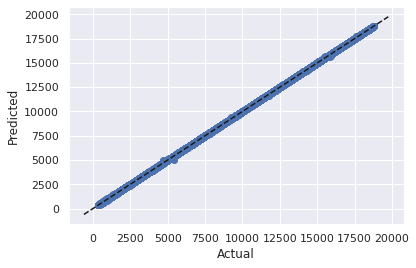

------- Test -------


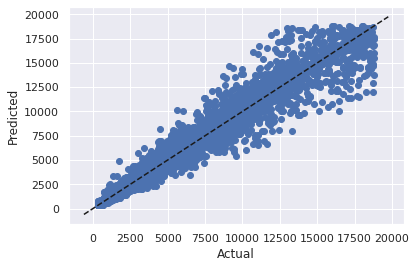

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished


#### AdaBoostRegressor ####
RMSE: 1363.6664
CV-RMSE: 1403.4983
--- Test Performance ---
RMSE: 1378.5927
Accuracy: 87.94%

MSE    : 1900517.83 
MAE    : 989.83 
RMSE   : 1378.59 


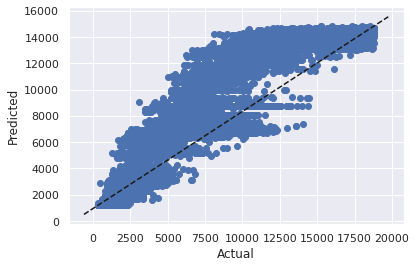

------- Test -------


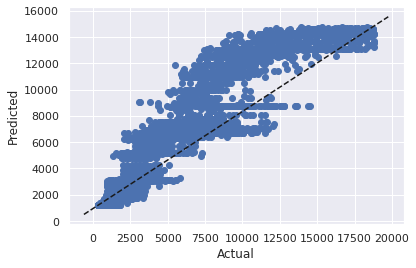

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


#### GradientBoostingRegressor ####
RMSE: 717.1905
CV-RMSE: 741.2606
--- Test Performance ---
RMSE: 723.2312
Accuracy: 96.68%

MSE    : 523063.41 
MAE    : 400.35 
RMSE   : 723.23 


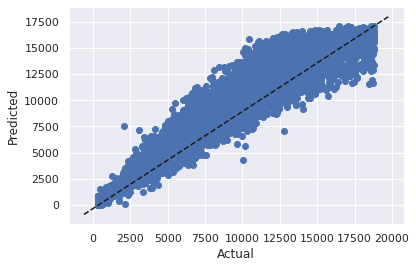

------- Test -------


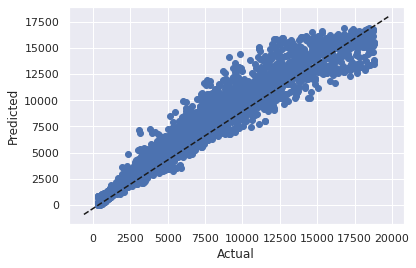

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.5s finished


#### RandomForestRegressor ####
RMSE: 206.6149
CV-RMSE: 558.1537
--- Test Performance ---
RMSE: 538.8634
Accuracy: 98.16%

MSE    : 290373.80 
MAE    : 269.65 
RMSE   : 538.86 


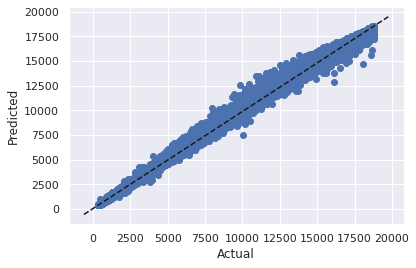

------- Test -------


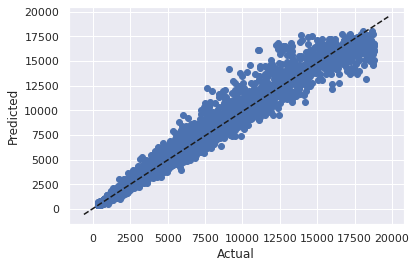

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


#### KNeighborsRegressor ####
RMSE: 624.3447
CV-RMSE: 814.2456
--- Test Performance ---
RMSE: 765.9276
Accuracy: 96.28%

MSE    : 586645.06 
MAE    : 400.15 
RMSE   : 765.93 


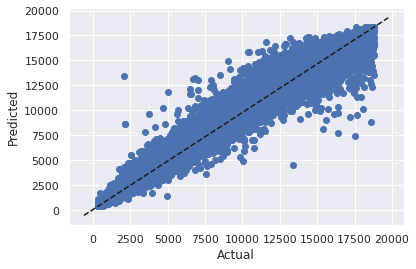

------- Test -------


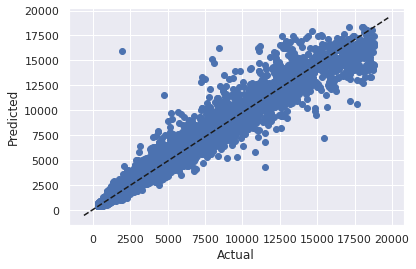

Iteration 1, loss = 2723852.97248480
Iteration 2, loss = 438802.76472719
Iteration 3, loss = 333306.91263918
Iteration 4, loss = 291535.76018735
Iteration 5, loss = 260731.20045027
Iteration 6, loss = 242104.31810334
Iteration 7, loss = 232051.79933605
Iteration 8, loss = 221313.18981670
Iteration 9, loss = 215456.49421556
Iteration 10, loss = 208885.52104071
Iteration 11, loss = 203978.97990403
Iteration 12, loss = 201236.09634864
Iteration 13, loss = 198805.43683728
Iteration 14, loss = 193854.15202311
Iteration 15, loss = 192155.20049873
Iteration 16, loss = 189869.31422911
Iteration 17, loss = 188692.17936777
Iteration 18, loss = 184714.26618748
Iteration 19, loss = 183975.49676531
Iteration 20, loss = 182449.46149427
Iteration 21, loss = 182096.26118595
Iteration 22, loss = 176693.99797373
Iteration 23, loss = 178202.46370256
Iteration 24, loss = 175679.47769160
Iteration 25, loss = 173135.27461057
Iteration 26, loss = 171561.15036430
Iteration 27, loss = 169286.18417843
Iteration

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.7min finished


#### MLPRegressor ####
RMSE: 495.2970
CV-RMSE: 560.5523
--- Test Performance ---
RMSE: 1081.1060
Accuracy: 92.58%

MSE    : 1168790.26 
MAE    : 306.92 
RMSE   : 1081.11 


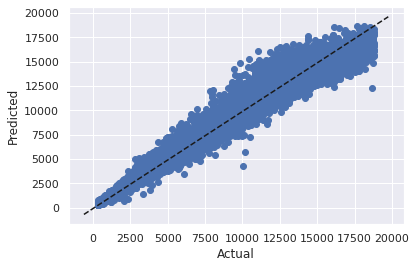

------- Test -------


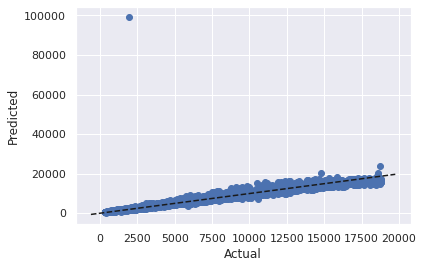

In [23]:
for m in model_dict:
    display_model_performance(m, model_dict[m])

In [ ]:
models_

In [ ]:
models_[3].feature_importances_

In [ ]:
diamonds

In [ ]:
ordem = ['carat','y','clarity','color','z','x','depth','table','cut']
sixbest = ['carat','y','clarity','color','z','x']
best = ['carat','y','z','x','depth','table']
X=df_diamonds.drop('price', axis=1)[sixbest]
y=df_diamonds['price']

In [ ]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression, mutual_info_regression
#X_new = SelectKBest(mutual_info_regression, k=4).fit_transform(X, y)
#X_new

In [ ]:
#from sklearn.feature_selection import SequentialFeatureSelector

#tic_fwd = time()
#sfs_forward = SequentialFeatureSelector(lasso, n_features_to_select=2,
#                                        direction='forward').fit(X, y)
#toc_fwd = time()

#tic_bwd = time()
#sfs_backward = SequentialFeatureSelector(lasso, n_features_to_select=2,
#                                         direction='backward').fit(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=1)

In [ ]:
sc=MinMaxScaler()
X_train_tx=sc.fit_transform(X_train)
X_test_tx=sc.transform(X_test)

In [ ]:
dataset_1=(X_train, X_test, y_train, y_test, 'dataset_1')

In [ ]:
# Blank lists for all the details
model_name=[]
model_=[]
cv_score_test=[]
cv_score_train=[]
mse_=[]
mae_=[]
rmse_=[]
r2_=[]

In [ ]:
def run_model(model, dataset, modelname):
    model.fit(dataset[0], dataset[2])
    accuracies=cross_val_score(estimator=model, X=dataset[0], y=dataset[2], cv=5, verbose=1, n_jobs=-1)
    y_pred=model.predict(dataset[1])
    print('')
    score_1=model.score(dataset[1], dataset[3])
    print(f'#### {modelname} ####')
    print("score :%.4f" %score_1)
    print(accuracies)
    
    
    mse=mean_squared_error(dataset[3], y_pred)
    mae=mean_absolute_error(dataset[3], y_pred)
    rmse=mean_squared_error(dataset[3], y_pred)**0.5
    r2=r2_score(dataset[3], y_pred)
    
    print('')
    print('MSE    : %0.2f ' % mse)
    print('MAE    : %0.2f ' % mae)
    print('RMSE   : %0.2f ' % rmse)
    print('R2     : %0.2f ' % r2)
    
    ## appending to the lists
    
    model_name.append(modelname)
    model_.append(model)
    cv_score_test.append(score_1)
    cv_score_train.append(np.mean(accuracies))
    mse_.append(mse)
    mae_.append(mae)
    rmse_.append(rmse)
    r2_.append(r2)

In [ ]:
model_dict={'DecisionTreeRegressor': DecisionTreeRegressor(),
            'AdaBoostRegressor': AdaBoostRegressor(),
            'GradientBoostingRegressor': GradientBoostingRegressor(),
            'RandomForestRegressor': RandomForestRegressor(),
            'MLPRegressor': MLPRegressor(hidden_layer_sizes=(200, 100,), batch_size=100, learning_rate_init=0.004, learning_rate="adaptive", max_iter=700, verbose=True)
           }

In [ ]:
for models in model_dict:
    run_model(model_dict[models], dataset_1, models)

In [ ]:
accuracy_data=pd.DataFrame(zip(model_name, cv_score_test, cv_score_train, mse_, mae_, rmse_, r2_), columns=['Model', 'CV Test score', 'CV Train score (mean)', '%%SVGean Squared error', 'Mean Absolute error', 'Root Mean Squared error', 'R2 Score'])

In [ ]:
accuracy_data

In [ ]:
model_[0].feature_importances_

In [ ]:
df_diamonds['price'].max()

In [ ]:
diamond.shape

In [34]:
df_diamonds[df_diamonds.z >11]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
48410,0.51,Very Good,E,VS1,61.8,54.7,1970.0,5.12,5.15,31.8,2.0


In [35]:
df_diamonds[df_diamonds.z == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
2207,1.00,Premium,G,SI2,59.1,59.0,3142.0,6.55,6.48,0.0,3.0
2314,1.01,Premium,H,I1,58.1,59.0,3167.0,6.66,6.60,0.0,3.0
4791,1.10,Premium,G,SI2,63.0,59.0,3696.0,6.50,6.47,0.0,4.0
5471,1.01,Premium,F,SI2,59.2,58.0,3837.0,6.50,6.47,0.0,3.0
10167,1.50,Good,G,I1,64.0,61.0,4731.0,7.15,7.04,0.0,5.0
11182,1.07,Ideal,F,SI2,61.6,56.0,4954.0,0.00,6.62,0.0,4.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139.0,0.00,0.00,0.0,3.0
13601,1.15,Ideal,G,VS2,59.2,56.0,5564.0,6.88,6.83,0.0,4.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381.0,0.00,0.00,0.0,4.0
24394,2.18,Premium,H,SI2,59.4,61.0,12631.0,8.49,8.45,0.0,5.0


In [36]:
df_diamonds[df_diamonds.x == 0]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
11182,1.07,Ideal,F,SI2,61.6,56.0,4954.0,0.0,6.62,0.0,4.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139.0,0.0,0.00,0.0,3.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381.0,0.0,0.00,0.0,4.0
24520,1.56,Ideal,G,VS2,62.2,54.0,12800.0,0.0,0.00,0.0,5.0
26243,1.20,Premium,D,VVS1,62.1,59.0,15686.0,0.0,0.00,0.0,4.0
27429,2.25,Premium,H,SI2,62.8,59.0,18034.0,0.0,0.00,0.0,5.0
49556,0.71,Good,F,SI2,64.1,60.0,2130.0,0.0,0.00,0.0,3.0
49557,0.71,Good,F,SI2,64.1,60.0,2130.0,0.0,0.00,0.0,3.0


In [52]:
df_diamonds[df_diamonds.depth <50]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
4518,1.00,Fair,G,SI1,43.0,59.0,3634.0,6.32,6.27,3.97,3.0
6341,1.00,Fair,G,VS2,44.0,53.0,4032.0,6.31,6.24,4.12,3.0
10377,1.09,Ideal,J,VS2,43.0,54.0,4778.0,6.53,6.55,4.12,4.0


In [49]:
df_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43,1.0
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31,1.0
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31,1.0
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63,1.0
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75,1.0


In [61]:
df_diamonds[df_diamonds.depth <52]

,carat,cut,color,clarity,depth,table,price,x,y,z,carat_cat
4518,1.00,Fair,G,SI1,43.0,59.0,3634.0,6.32,6.27,3.97,3.0
6341,1.00,Fair,G,VS2,44.0,53.0,4032.0,6.31,6.24,4.12,3.0
10377,1.09,Ideal,J,VS2,43.0,54.0,4778.0,6.53,6.55,4.12,4.0
16857,1.43,Fair,I,VS1,50.8,60.0,6727.0,7.73,7.25,3.93,5.0
36503,0.30,Fair,E,VVS2,51.0,67.0,945.0,4.67,4.62,2.37,1.0
